In [5]:
"""
Exp06B：execution delay and risk control

Goal:
- Test how risk controls can mitigate execution delay sensitivity?



Fixed:
- Asset: SPY
- Signal: fixed (MA_WINDOW = 80)
- Regime / sample


Sweep: 
- EXEC_DELAY ∈ {0, 1}
- Risk strategy: 
    1) No risk control 
    2) Vol_targeting
    3) Risk-off gate



--------------------------------------------------
Downside Distribution Diagnostics (Post-Execution: distribution-level sanity check)

After introducing execution delays and risk controls, we examine how
downside return behavior evolves, focusing on left-tail intensity rather
than average performance.

--------------------------------------------------


"""

'\nExp06B：execution delay and risk control\n\nGoal:\n- Test how risk controls can mitigate execution delay sensitivity?\n\n\n\nFixed:\n- Asset: SPY\n- Signal: fixed (MA_WINDOW = 80)\n- Regime / sample\n\n\nSweep: \n- EXEC_DELAY ∈ {0, 1}\n- Risk strategy: \n    1) No risk control \n    2) Vol_targeting\n    3) Risk-off gate\n\n\n\n--------------------------------------------------\nDownside Distribution Diagnostics (Post-Execution: distribution-level sanity check)\n\nAfter introducing execution delays and risk controls, we examine how\ndownside return behavior evolves, focusing on left-tail intensity rather\nthan average performance.\n\n--------------------------------------------------\n\n\n'

In [6]:
import os
os.chdir("/Users/kim/Desktop/Quant-Research")
print(os.getcwd())

# os.chdir("..")
# print(os.getcwd())

/Users/kim/Desktop/Quant-Research


In [7]:
import pandas as pd
from runner import run

In [8]:
# Sweep: execution delay 

from copy import deepcopy
from config import Config
from dataclasses import replace


cfg_base = replace(Config(), 
                   MA_WINDOW=80,   # 和Exp02同
                  )  

delays = [0, 1]
risk_control = [('none', False), ('vol_target',False), ('none', True)] # none, vol_target, risk-off gate


rows = []


for d in delays:
    cfg_d = replace(cfg_base, EXEC_DELAY=d)

    for risk_mode, use_risk_off_gate in risk_control:   
        cfg_tmp = replace(cfg_d, RISK_MODE=risk_mode, USE_RISK_OFF_GATE=use_risk_off_gate)

    
        _, summary = run(cfg_tmp)
        summary["EXEC_DELAY"] = d # dict
        summary["RISK_MODE"] = risk_mode
        summary["USE_RISK_OFF_GATE"] = use_risk_off_gate
        rows.append(summary)

exp06 = pd.DataFrame(rows).sort_values(["EXEC_DELAY"]) # 汇总成一个 实验结果表（experiment table）

exp06


/Users/kim/Desktop/Quant-Research/data/loaders.py:19: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv(path, index_col=0, parse_dates=True)
/Users/kim/Desktop/Quant-Research/data/loaders.py:22: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  idx = pd.to_datetime(df.index, errors="coerce")
/Users/kim/Desktop/Quant-Research/data/loaders.py:19: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv(path, index_col=0, parse_dates=True)
/Users/kim/Desktop/Quant-Research/data/loaders.py:22: UserWarning: Could not infer format, so each element will be parsed in

,Annual Return,Max Drawdown,Sharpe,Total Turnover,N_obs,EXEC_DELAY,RISK_MODE,USE_RISK_OFF_GATE
0,0.249297,-0.082251,2.168994,108.000000,2437,0,none,False
1,0.213625,-0.073616,2.084295,103.935816,2437,0,vol_target,False
2,0.246636,-0.082251,2.149626,112.000000,2437,0,none,True
3,0.069690,-0.192385,0.663331,108.000000,2436,1,none,False
4,0.063086,-0.172345,0.656152,102.732187,2436,1,vol_target,False
5,0.067631,-0.200142,0.646185,110.000000,2436,1,none,True


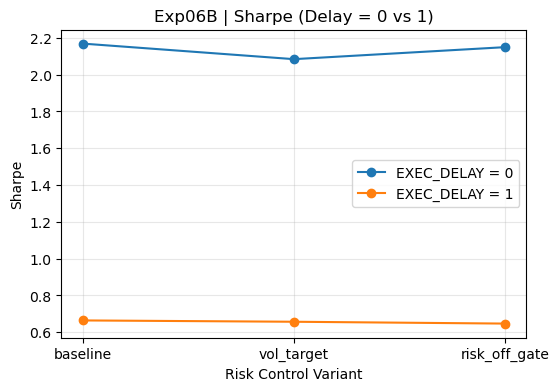

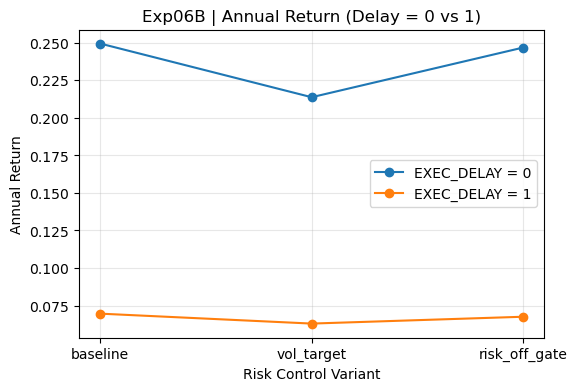

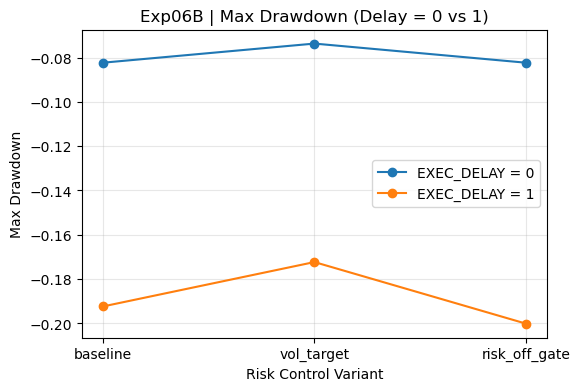

In [9]:
import matplotlib.pyplot as plt
import pandas as pd

df = exp06.copy()

# 给 risk 配置一个统一 label
def label(row):
    if row["USE_RISK_OFF_GATE"]:
        return "risk_off_gate"
    if row["RISK_MODE"] == "vol_target":
        return "vol_target"
    return "baseline"

df["variant"] = df.apply(label, axis=1)

order = ["baseline", "vol_target", "risk_off_gate"]
df["variant"] = pd.Categorical(df["variant"], categories=order, ordered=True)

# ===== 画图函数 =====
def plot_two_delay_lines(metric):
    fig, ax = plt.subplots(figsize=(6,4))

    for d in [0, 1]:
        sub = df[df["EXEC_DELAY"] == d].sort_values("variant")
        ax.plot(
            sub["variant"],
            sub[metric],
            marker="o",
            label=f"EXEC_DELAY = {d}"
        )

    ax.set_title(f"Exp06B | {metric} (Delay = 0 vs 1)")
    ax.set_xlabel("Risk Control Variant")
    ax.set_ylabel(metric)
    ax.legend()
    ax.grid(True, alpha=0.3)
    plt.show()

# ===== 图 =====
plot_two_delay_lines("Sharpe")
plot_two_delay_lines("Annual Return")
plot_two_delay_lines("Max Drawdown")